## Aufgabe
1) Logistische Regression - Spamklassifikation
    - Führen Sie die Spamklassifikation der vorherigen Übung mit einer logistischen Regression durch.
    - Erstellen Sie für die Auswertung eine ROC-Kurve.
2) Klassifikation - SA-Subset
    - Selektieren Sie nur Reihen mit den 3 häufigsten Labels aus dem SA-Subset (df = df[df['labels'].isin([b'normal.', b'smurf.', b'neptune.'])].copy()).
    - Führen Sie eine Klassifikation dieser 3 Klassen durch und finden Sie den besten Parameter für min_freq.

### Notizen

#### Linear Regression
1) Lineare Kombination der Features
    - $z = w_{1}x_{1} + w_{2}x_{2} + \ldots + w_{n}x_{n} + b$
        - $w_{i}$: Gewichte
        - $x_{i}$: Featurewerte
        - $b$: Bias (auch $-\Theta$)
2) Anwendung der Sigmoid Funktion
    - $\hat{y}=\sigma(z)=\frac{1}{1+\mathscr{e}^{-z}}$
    - $\hat{y}$ ist die vorhergesagte wahrscheinlichkeit, dass das Sample 1 ist

#### Loss Function
...

Für Hyperparameter am besten die scores einzeln visualisieren um zu sehen, wann der Score optimal ist und wann er wieder abfällt

### Aufgaben

#### Imports

In [132]:
import numpy as np
from sklearn.linear_model import LogisticRegression
import pandas as pd
import sklearn.metrics as skm
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as stat
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay


#### Aufgabe 1

##### Dataset

In [133]:
data = pd.read_csv(
    'https://raw.githubusercontent.com/AiDevNepal/ai-saturdays-workshop-8/master/data/spam.csv'
)
data

,text,target
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham
...,...,...
5567,This is the 2nd time we have tried 2 contact u...,spam
5568,Will Ì_ b going to esplanade fr home?,ham
5569,"Pity, * was in mood for that. So...any other s...",ham
5570,The guy did some bitching but I acted like i'd...,ham


In [134]:
data['target'].value_counts()

target
ham     4825
spam     747
Name: count, dtype: int64

In [135]:
data.describe()

,text,target
count,5572,5572
unique,5169,2
top,"Sorry, I'll call later",ham
freq,30,4825


Map ham/spam to 0/1 so i don't need custom scorers

In [136]:
data['target'] = data['target'].map({'ham': 0, 'spam': 1})

In [137]:
data.describe()

,target
count,5572.000000
mean,0.134063
std,0.340751
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [138]:
min_df_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 25, 30, 40, 50]
scores_precision = []
scores_recall = []

for min_df in min_df_values:
    countVectorizer = CountVectorizer(
        binary=True,
        stop_words='english',
        min_df=min_df,
        max_df=0.90
    )

    pipeline = Pipeline([
        ('vectorizer', countVectorizer),
        ('classifier', LogisticRegression())
    ])

    # stratify -> Verhältnis von spam/ham bleibt in etwa wie im gesamt-dataset
    X_train, X_test, y_train, y_test = train_test_split(
        data['text'],
        data['target'],
        test_size=0.15,
        random_state=42,
        stratify=data['target']
    )

    pipeline.fit(X_train, y_train)

    score_precision = skm.precision_score(pipeline.predict(X_test), y_test)
    score_recall = skm.recall_score(pipeline.predict(X_test), y_test)

    scores_precision.append(score_precision)
    scores_recall.append(score_recall)

    # cross_val_score(estimator=pipeline, X=X_train, y=y_train, scoring='precision')

In [139]:
scores_df = pd.DataFrame({
    'min_df': min_df_values,
    'scores_precision': scores_precision,
    'scores_recall': scores_recall
})

scores_melted = scores_df.melt(id_vars='min_df', var_name='Metric', value_name='Score')

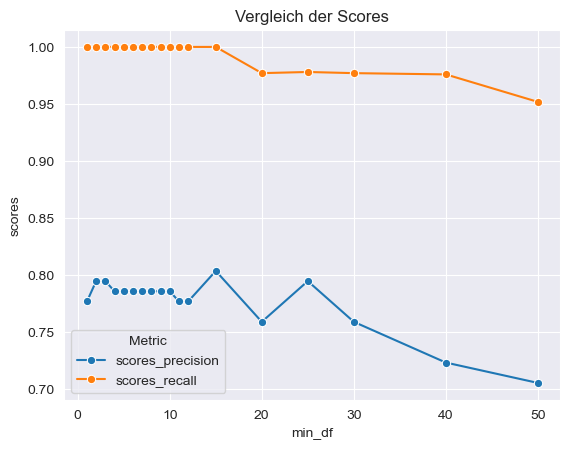

In [140]:
plot = sns.lineplot(data=scores_melted, x='min_df', y='Score', hue='Metric', marker='o')

plot.set_title("Vergleich der Scores")
plt.xlabel('min_df')
plt.ylabel('scores')
plt.grid(True)
plt.show()

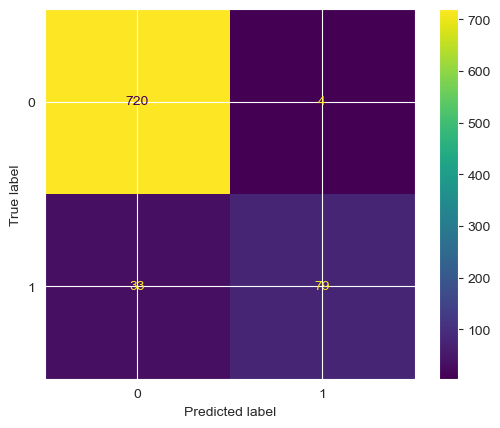

In [141]:
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test)